In [1]:
!export LD_LIBRARY_PATH=/opt/conda/lib
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir
!export PATH=/usr/local/cuda-11.7/bin:${PATH}

In [ ]:
# import the libraries

import logging
import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import random
from tqdm import tqdm
import pandas as pd

import h5py
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape,Conv1D,Flatten,Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass
from sklearn.utils import shuffle
AUTOTUNE = tf.data.AUTOTUNE
from sklearn.preprocessing import StandardScaler
import tqdm
import gc

os.environ['PATH']=os.environ['PATH']+':/usr/local/cuda/bin'
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir'

In [4]:
# define your plot style

best_style = {
    # "font.sans-serif": ["TeX Gyre Heros", "Helvetica", "Arial"],
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (10.0, 10.0),
    "font.size": 26,
    #"text.usetex": True,
    "axes.labelsize": "x-small",
    "axes.unicode_minus": False,
    "xtick.labelsize": "x-small",
    "ytick.labelsize": "x-small",
    "legend.fontsize": "x-small",
    "legend.handlelength": 1.0,
    "legend.borderpad": 0.5,
    "xtick.direction": "in",
    # "xtick.major.size": 12,
    # "xtick.minor.size": 6,
    # "xtick.major.pad": 6,
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    # "ytick.major.size": 12,
    # "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,

}
plt.style.use(best_style)

In [5]:
# Trained Models with three different weight initializations

model_name1 = 'working_model_1M-2-034_seed38_v2.keras'
model_name2 = 'working_model_1M-2-034_seed128_v2.keras'
model_name3 = 'working_model_1M-2-034_seed1024_v2.keras'

In [6]:
# data with single image for a particular w value. 
# This data can be generated by modifying the deeplentronomy template to fix the w value.

data_path = '/deepskieslab/stronglensing/hsbi/datasets/'
train_image_dir = 'w0_8param_fixzv_train_1M'
image_dir_2 = 'w0_8param_w0-2_1'
image_dir_18 = 'w0_8param_w0-18_1'
image_dir_16 = 'w0_8param_w0-16_1'
image_dir_14 = 'w0_8param_w0-14_1'
image_dir_12 = 'w0_8param_w0-12_1'
image_dir_1 = 'w0_8param_w0-1_1'
image_dir_08 = 'w0_8param_w0-08_1'
image_dir_06 = 'w0_8param_w0-06_1'
image_dir_04 = 'w0_8param_w0-04_1'
column_name = "w0-g" # dark energy equation-of-state parameter

In [7]:
# Read the images and the corresponding metadata

def read_image_files(image_dir):
    images = np.load(data_path+image_dir+'/CONFIGURATION_1_images.npy', allow_pickle=True)
    metadata = pd.read_csv(data_path+image_dir+'/CONFIGURATION_1_metadata.csv')
    return images, metadata

images_train, metadata_train = read_image_files(train_image_dir)
images_2, metadata_2 = read_image_files(image_dir_2)
images_18, metadata_18 = read_image_files(image_dir_18)
images_16, metadata_16 = read_image_files(image_dir_16)
images_14, metadata_14 = read_image_files(image_dir_14)
images_12, metadata_12 = read_image_files(image_dir_12)
images_1, metadata_1 = read_image_files(image_dir_1)
images_08, metadata_08 = read_image_files(image_dir_08)
images_06, metadata_06 = read_image_files(image_dir_06)
images_04, metadata_04,  = read_image_files(image_dir_04)

In [9]:
# List of w and einstein radius
w_all = metadata_train["w0-g"].to_numpy()
einstein_radius_all = metadata_train["PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g"].to_numpy()

In [10]:
# sort according to the w value
sorted_inx = np.argsort(w_all)
w_all_sorted = w_all[sorted_inx]
einstein_radius_all_sorted = einstein_radius_all[sorted_inx]

In [11]:
# combined all images to one array of shape (n_images, 1, 32, 32)
images = np.concatenate((images_2, images_18, images_16, images_14, images_12, images_1, images_08, images_06, images_04), axis=0)
theta = np.array([-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4])

/tmp/ipykernel_1345780/1526992155.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


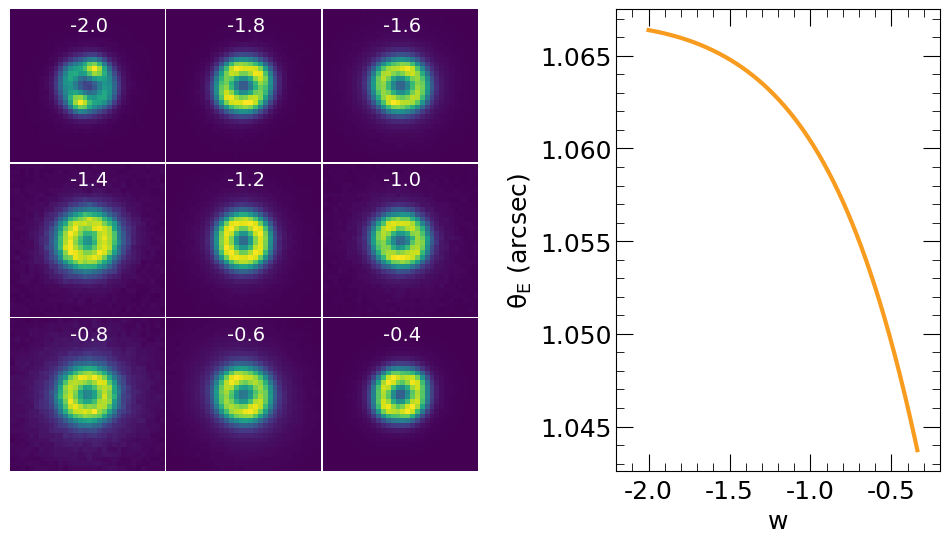

In [15]:
num_rows = 3
num_cols = 3

# Create a figure with GridSpec
fig = plt.figure(figsize=(12, 6))
# gs = GridSpec(1, 2, width_ratios=[0.4, 0.2], wspace=0.3)
gs = GridSpec(1, 2, figure=fig, width_ratios=[0.65, 0.45], wspace=0.35)

# Left plot: 3x3 images with annotations
# left_gs = GridSpec(num_rows, num_cols, hspace=0.01, wspace=0.01)
left_gs = gs[0,0].subgridspec(num_rows, num_cols, hspace=0.01, wspace=0.01)
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        ax = plt.subplot(left_gs[i, j])
        ax.imshow(images[index][0], cmap='viridis', aspect='auto')  # Assuming grayscale images
        # ax.text(6, 4, r'$w_{\mathrm{True}} = $' + str(theta[index]), color="k", fontsize=12.5)
        ax.text(12, 4, str(theta[index]), color="white", fontsize=14)
        ax.axis('off')

# Right plot: w vs einstein radius
ax1 = plt.subplot(gs[0, 1])
lw = 1.2
ax1.plot(w_all_sorted, einstein_radius_all_sorted, color="#f89c20", lw=3)
ax1.set_xlim(-2.2, -0.2)
ax1.set_xlabel(r'$w$', fontsize='x-small')
# ax1.set_ylabel(r'$Einstein\ Radius\ \theta_{E}$', fontsize='small')
# ax1.set_ylabel(r'$\theta_{E}$', fontsize='small')
ax1.set_ylabel(r'$\theta_{E}$ (arcsec)', fontsize='x-small')
ax1.tick_params(axis='both', which='both', labelsize='x-small')
ax1.set_aspect('auto',adjustable='box')

plt.tight_layout()
plt.savefig('images_w_thetaE.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
images = np.einsum('lkij->lijk',images)
# theta = metadata[column_name].to_numpy()


In [19]:
# normalize image each image by the sum of all pixels, make it such that the sum of all pixels is 1024 (32 X32)
images = 1024*(images/np.sum(images, axis=(1,2), keepdims=True))

# manually standardies pixels across all images. 
# In this analysis we do not standerdize the images and parameter. Hence we use mean=0 and std=1.0

images = images.reshape(images.shape[0], -1)
# means_image = np.mean(images, axis=0)
# std_image = np.std(images, axis=0)
means_image = 0.0
std_image = 1.0
images = (images - means_image) / std_image
images = images.reshape(images.shape[0], 32, 32, 1)


#manually standardize the theta (w)
mean_theta = 0.0 
std_theta = 1.0 
theta = (theta - mean_theta)/std_theta

In [ ]:
# load models with different seeds

model1 = tf.keras.models.load_model(model_name1)
model2 = tf.keras.models.load_model(model_name2)
model3 = tf.keras.models.load_model(model_name3)

### Calculate the Analytical Posterior 

The analytical equation to calculate the posterior is given by

\begin{equation}
\begin{split}
    p(w|\{x\}) &= \frac{p(w)~\prod_{i}r(x_i|w)}{\int dw^{\prime}~ p(w^{\prime})~\prod_{i}r(x_{i}|w^{\prime})},\\
        &= p(w)~\left( \int dw^{\prime}~p(w^{\prime})~\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)} \right)^{-1}.
\end{split}
\end{equation}

```likelihood_diff``` function calculates $log\ r(x|w^{\prime}) - log\ r(x|w)$  for one image $x$ 

This is same as calculating $\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_likelihood``` function calculates  $\sum_{i} log\ r(x_{i}|w^{\prime}) - log\ r(x_{i}|w)$ for a population of strong lens images $\{x_{i}\}$

This is same as calculating $\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_posterior``` calculates the sum of posterior for all the theta ($w$) values and gives the inverse of the sum as shown in the equation

In [22]:
import numba as nb

@nb.jit
def get_logr_distribution(model, images, sample_theta):
    '''
    Function to predict the log likelihood-to-evidence ratio (logr) of the test data

    Input:
    model: The trained model 
    images: test images
    sample_theta: a list of theta values to compute logr for
    '''
    output_probs = []
    for image in images:
        test_image_array = np.concatenate([image[np.newaxis, :]]*len(sample_theta), axis=0)
        output = model.predict([test_image_array, sample_theta], verbose=0).flatten()
        output_probs.append(output)
    return np.array(output_probs)

class Posterior:
    def __init__(self, lnr, thetas):
        self.lnr = lnr
        self.thetas = thetas

    def likelihood_diff(self, image_index):
        # exp_diff_lnr = np.empty((len(self.thetas), len(self.thetas)))
        diff_lnr_list = np.empty((len(self.thetas), len(self.thetas)))
        for i in range(len(self.thetas)):
            diff_lnr = self.lnr[image_index, i] - self.lnr[image_index]
            # exp_diff_lnr[i] = np.exp(diff_lnr)
            diff_lnr_list[i] = diff_lnr
        # return exp_diff_lnr
        return diff_lnr_list

    def get_joint_likelihood(self, n_images):
        likelihood = np.empty((n_images, len(self.thetas), len(self.thetas)))
        for i in range(n_images):
            likelihood[i] = self.likelihood_diff(i)
        # joint_likelihood = np.prod(likelihood, axis=0)
        joint_likelihood = np.sum(likelihood, axis=0)
        joint_likelihood = np.exp(joint_likelihood)
        return joint_likelihood
    
    def get_joint_posterior(self, n_images):
        joint_likelihood = self.get_joint_likelihood(n_images)
        joint_posterior = 1. / np.sum(joint_likelihood, axis=0)
        return joint_posterior
    
def get_joint_posterior_probability(lnr, thetas, n_images):
    '''
    Function to sample from the posterior probability distribution.

    Output:
    The posterior probability, mean and standard deviation
    '''
    posterior = Posterior(lnr, thetas)
    joint_posterior = posterior.get_joint_posterior(n_images)
    sampled_values = np.random.choice(thetas, size=1000, p=joint_posterior)
    weighted_mean = np.mean(sampled_values)
    weighted_std_dev = np.std(sampled_values)
    # weighted_mean = np.sum(thetas * joint_posterior) / np.sum(joint_posterior)
    # weighted_std_dev = np.sqrt(np.sum(joint_posterior * (thetas - weighted_mean)**2) / np.sum(joint_posterior))
    return joint_posterior, weighted_mean, weighted_std_dev

### Plot of the test image and the corresponding posterior for the three models with randome weight initialization

In [23]:
# Plotting function to get the image-posterior figure 

from matplotlib import gridspec

def grid2(nx=4, ny=2, height=6., large_margin=0.14, small_margin=0.03, sep=0.03, cbar_width=0.06):
    # Geometry
    left = large_margin
    right = large_margin
    top = small_margin
    bottom = large_margin

    panel_size = (1. - top - bottom - (ny - 1)*sep)/ny
    width = height*(left + nx*panel_size + cbar_width + nx*sep + right)

    # wspace and hspace are complicated beasts
    avg_width_abs = (height*panel_size * nx * ny + ny * cbar_width * height) / (nx * ny + ny)
    avg_height_abs = height*panel_size
    wspace = sep * height / avg_width_abs
    hspace = sep * height / avg_height_abs

    # Set up figure
    fig = plt.figure(figsize=(width, height))
    gs = gridspec.GridSpec(ny, nx + 1, width_ratios=[1.]*nx + [cbar_width], height_ratios=[1.] * ny)
    plt.subplots_adjust(
        left=left * height / width,
        right=1. - right * height / width,
        bottom=bottom,
        top=1. - top,
        wspace=wspace,
        hspace=hspace,
    )
    return fig, gs


def grid2_width(nx=4, ny=2, width=7.1, large_margin=0.14, small_margin=0.03, sep=0.03, cbar_width=0.06):
    left = large_margin
    right = large_margin
    top = small_margin
    bottom = large_margin
    panel_size = (1. - top - bottom - (ny - 1)*sep)/ny
    height = width / (left + nx*panel_size + cbar_width + nx*sep + right)
    return grid2(nx, ny, height, large_margin, small_margin, sep, cbar_width)

In [ ]:
# list of w values to calculate the logr for
sample_theta_unstd = np.linspace(-2.5, -0.15, 1000)
sample_theta = (sample_theta_unstd - mean_theta)/std_theta

# Get logr for the w
x_test_lnr_model1 = get_logr_distribution(model1, images, sample_theta)
x_test_lnr_model2 = get_logr_distribution(model2, images, sample_theta)
x_test_lnr_model3 = get_logr_distribution(model3, images, sample_theta)

In [26]:
x_test_copy = images[4:]
theta_test_copy = theta[4:]
x_test_lnr_model1 = x_test_lnr_model1[4:]
x_test_lnr_model2 = x_test_lnr_model2[4:]
x_test_lnr_model3 = x_test_lnr_model3[4:]

/tmp/ipykernel_1328493/1466675953.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for item in ax.get_xticklabels()])


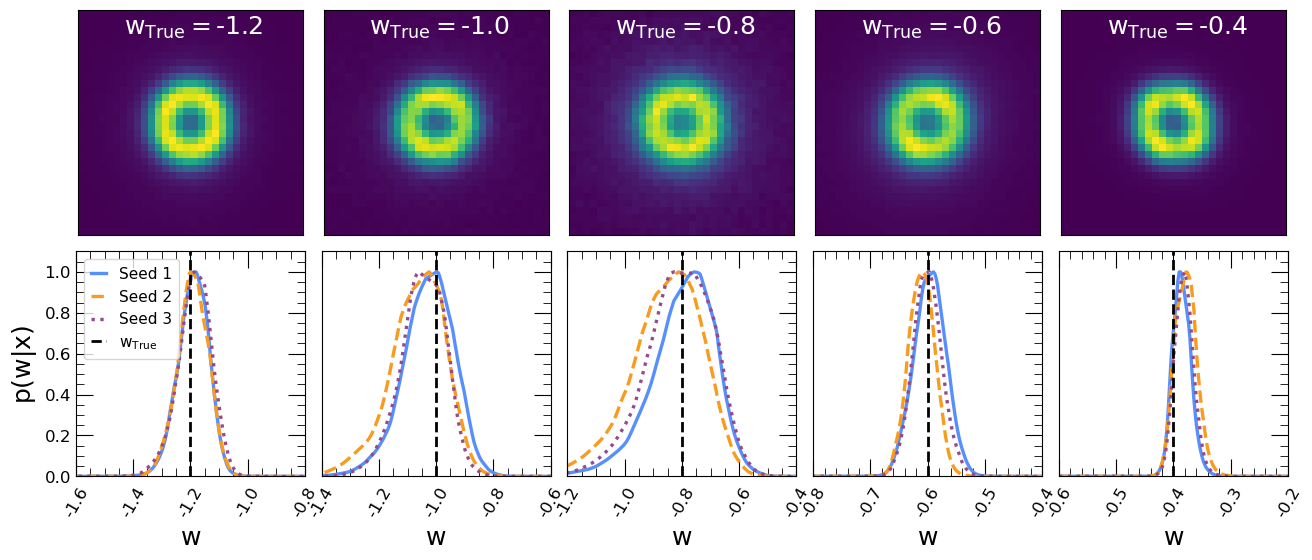

In [31]:
cols = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
ncols = 5
nrows = 2

fig, gs = grid2_width(ncols, nrows, sep=0.03, width=14.0)

#plot for w>-1.2
lw=2.4

for i, image in enumerate(x_test_copy):
    ax = plt.subplot(gs[i])
    im = plt.imshow(
        x_test_copy[i],
        cmap='viridis',
        origin="lower",
        alpha=1.
    )
    ax.text(6, 28, r'$w_{\mathrm{True}} = $'+str(theta_test_copy[i]), color="white", fontsize=18)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    if i == 0:
        ax = plt.subplot(gs[ncols])
        cbar = plt.colorbar(im, cax=ax, pad=0.01)
        cbar.remove() 
    ax = plt.subplot(gs[ncols + 1 + i])
    posterior1, posterior_mean1, posterior_std1 = get_joint_posterior_probability(x_test_lnr_model1[i:i+1], sample_theta, 1)
    posterior2, posterior_mean2, posterior_std2 = get_joint_posterior_probability(x_test_lnr_model2[i:i+1], sample_theta, 1)
    posterior3, posterior_mean3, posterior_std3 = get_joint_posterior_probability(x_test_lnr_model3[i:i+1], sample_theta, 1)
    plt.plot(sample_theta_unstd, posterior1/np.max(posterior1), ls='-', lw=lw, color="#5790fc",  label='Seed 1')
    plt.plot(sample_theta_unstd, posterior2/np.max(posterior2), ls='--', lw=lw, color =  "#f89c20", label='Seed 2')
    plt.plot(sample_theta_unstd, posterior3/np.max(posterior3),  ls=':', lw=lw, color = "#964a8b",label='Seed 3')

    plt.xlabel(r'$w$', fontsize='x-small')
    plt.tick_params(axis='both', which='both', labelsize='12')
    plt.ylim(0.0, 1.1)
    # set xlimits
    if i == 0:
        plt.vlines(theta_test_copy[i], 0, 1.1, color='k', ls='--', lw=2, label=r'$w_{\mathrm{True}}$')
        plt.xlim(-1.6, -0.8)
    elif i == 1:
        plt.vlines(theta_test_copy[i], 0, 1.1, color='k', ls='--', lw=2)
        plt.xlim(-1.4, -0.6)
    elif i == 2:
        plt.vlines(theta_test_copy[i], 0, 1.1, color='k', ls='--', lw=2)
        plt.xlim(-1.2, -0.4)
    elif i == 3:
        plt.vlines(theta_test_copy[i], 0, 1.1, color='k', ls='--', lw=2)
        plt.xlim(-0.8, -0.4)
    elif i == 4:
        plt.vlines(theta_test_copy[i], 0, 1.1, color='k', ls='--', lw=2)
        plt.xlim(-0.6, -0.2)

    if i == 0:
        plt.tick_params(axis='y', which='both')
        plt.tick_params(axis='x', which='both', rotation=60)
        plt.legend(loc='upper left', fontsize=11)
        plt.ylabel(r'$p(w|x)$', fontsize='x-small')
    else:  
        plt.tick_params(axis='y', which='both', left=False, labelbottom=False) 
        plt.tick_params(axis='x', which='both', rotation=60)
        ax.set_yticklabels(['' for item in ax.get_xticklabels()])
        # ax.legend([r'$w_{True} = $'+str(theta_test_copy[i])], loc='upper left', fontsize=8.4)

    
# plt.tight_layout()
plt.savefig('image_posterior.pdf', bbox_inches='tight', dpi=400)
plt.show()    